In [2]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

1. Перших 2 байти завжди порожні тому ми їх пропускаємо зчитуючи >H тип unsigned short який займає 2 байти

2. 3-ій байт вказує на тип даних
  * 0x08: unsigned byte 
  * 0x09: signed byte 
  * 0x0B: short (2 bytes) 
  * 0x0C: int (4 bytes) 
  * 0x0D: float (4 bytes) 
  * 0x0E: double (8 bytes)
  
3. Наступний байт вказує кількість вимірів матриці

4. Далі послідовно для кожного виміру вказано його розмір як 4-байтове ціле число. Тобто, починаючи з п’ятого байту, три групи по 4 байти вказують на розмірність тривимірної матриці, а саме

In [6]:
print('Labels shape')

with gzip.open('dataset/train-labels-idx1-ubyte.gz', 'rb') as f:
    print(struct.unpack('>HBB', f.read(4)))
    print(struct.unpack('>I', f.read(4)))

print('\nImages shape')
with gzip.open('dataset/train-images-idx3-ubyte.gz', 'rb') as f:
    print(struct.unpack('>HBB', f.read(4)))
    print(struct.unpack('>III', f.read(12)))
    
    

Labels shape
(0, 8, 1)
(60000,)

Images shape
(0, 8, 3)
(60000, 28, 28)


In [7]:
# script for reading MNIST file format
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [8]:
raw_train = read_idx('dataset/train-images-idx3-ubyte.gz')
X_train = raw_train.reshape(60000, 28 * 28)
y_train = read_idx('dataset/train-labels-idx1-ubyte.gz')

raw_test = read_idx('dataset/t10k-images-idx3-ubyte.gz')
X_test = raw_test.reshape(10000, 28 * 28)
y_test = read_idx('dataset/t10k-labels-idx1-ubyte.gz')

In [9]:
X_test = X_test / 255
X_train = X_train / 255

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
import pandas as pd

def get_subset(X, y, n):
    df = pd.DataFrame(data=X)
    df['label'] = y
    df = df.groupby('label').apply(pd.DataFrame.sample, n=n).reset_index(drop=True)
    
    return df.iloc[:, :-1].copy(), df.label.copy()

In [12]:
X_subset, y_subset = get_subset(X_train, y_train, 100)

In [13]:
from sklearn.svm import LinearSVC

In [ ]:
%time LinearSVC(C=0.001, verbose=True, dual=False, max_iter=1000000).fit(X_subset, y_subset)

In [14]:
from sklearn.model_selection import cross_val_score

parameters = np.power(10.0, np.arange(-5, 5))
scores = []

for c in parameters:
    svc = LinearSVC(C=c, verbose=True, dual=False, max_iter=1000000)
    score = cross_val_score(svc, X_subset, y_subset, cv=5, scoring='accuracy').mean()
    scores.append(score)
    print(c, scores[-1])

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]1e-05 0.693
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.0001 0.784
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.001 0.8390000000000001
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.01 0.8710000000000001
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.1 0.867
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]1.0 0.833
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]10.0 0.8310000000000001
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]100.0 0.826
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]1000.0 0.825
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]10000.0 0.826


0.8710000000000001 0.01


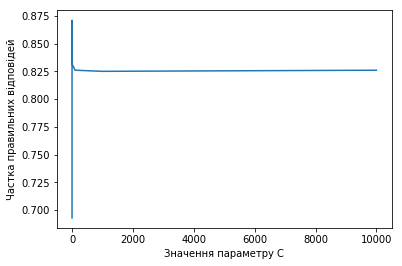

In [15]:
plt.plot(parameters, scores)

# plt.xticks(parameters)

plt.xlabel('Значення параметру C')
plt.ylabel('Частка правильних відповідей')

xmax = max(scores)
xindex = scores.index(xmax)
print(xmax, parameters[xindex])

In [17]:
%time svm = LinearSVC(C=0.01, verbose=True, dual=False, max_iter=1000000).fit(X_train, y_train)

[LibLinear]Wall time: 42 s


In [18]:
%time y_pred = svm.predict(X_test)

Wall time: 192 ms


In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9171

In [20]:
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормалізована матриця помилок")
    else:
        print('Матриця помилок, без нормалізації')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Вірний клас')
    plt.xlabel('Передбачений клас')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

Матриця помилок, без нормалізації
[[ 961    0    2    2    0    4    7    2    1    1]
 [   0 1111    2    2    0    1    4    1   14    0]
 [   7    7  916   17   11    5   13   12   39    5]
 [   5    1   21  918    2   19    4   13   19    8]
 [   1    3    2    1  919    1    9    1    7   38]
 [   9    3    1   39   10  765   20    8   29    8]
 [  12    3    7    2    7   15  909    0    3    0]
 [   2    9   24    5    9    1    1  944    2   31]
 [   9   13    6   19   15   37   12   12  840   11]
 [   9    8    2   14   40   11    0   26   11  888]]


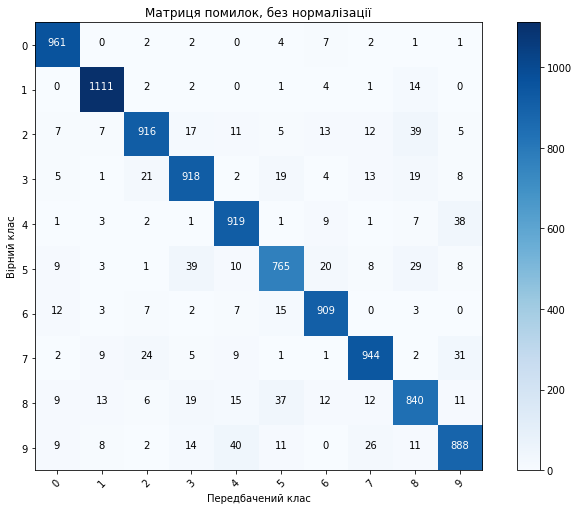

In [21]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                      title='Матриця помилок, без нормалізації')

In [22]:
# save classifier
from sklearn.externals import joblib
joblib.dump(svm , 'app/classifiers/svm.pkl') 

['app/classifiers/svm.pkl']